In [1]:
import os
import tarfile
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32

In [2]:
RELIANCE_PATH = "RILO - Copy.csv"

def load_csv(reliance_path=RELIANCE_PATH):
    return pd.read_csv(reliance_path)

reliance_set = load_csv()
reliance_set.head()

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
0,RELIANCE,EQ,1-Jan-16,1014.60,1009.80,1018.9,1008.20,1013.6,1015.35,1015.52,1238135,1.257353e+09,30701,529539,42.77
1,RELIANCE,EQ,4-Jan-16,1015.35,1005.00,1013.8,986.70,993.2,995.30,998.91,6896571,6.889070e+09,66235,4974602,72.13
2,RELIANCE,EQ,5-Jan-16,995.30,1000.30,1010.0,997.00,1005.0,1005.15,1003.41,3416459,3.428125e+09,59935,1987804,58.18
3,RELIANCE,EQ,6-Jan-16,1005.15,1007.60,1038.4,1000.40,1029.1,1032.20,1028.15,6116855,6.289073e+09,160947,2912662,47.62
4,RELIANCE,EQ,7-Jan-16,1032.20,1021.05,1028.0,1008.05,1018.9,1013.25,1016.73,4512219,4.587700e+09,105075,2474491,54.84


<p>Will likely drop dates, series and symbol, since they either do not change or have no real effect on what will be our goal. <b>The closing price.</b></p>

In [3]:
reliance_set.describe()

,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
count,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1.324000e+03,1.324000e+03,1.324000e+03,1.324000e+03,1324.000000
mean,1311.043807,1313.436254,1328.644864,1297.260876,1312.213935,1312.119864,1313.226805,8.873225e+06,1.283806e+10,1.959810e+05,3.583648e+06,45.719252
std,377.738596,379.462103,384.037322,372.970908,378.085826,377.840674,378.449456,7.489692e+06,1.380620e+10,1.572366e+05,2.424792e+06,13.352733
min,780.900000,791.750000,793.400000,779.100000,781.200000,780.900000,785.510000,3.621700e+05,3.812024e+08,1.000000e+00,1.252240e+05,11.480000
25%,1012.837500,1014.000000,1023.725000,1003.425000,1012.862500,1013.037500,1013.945000,4.159562e+06,4.447683e+09,9.206475e+04,2.038083e+06,36.517500
50%,1230.075000,1231.750000,1244.300000,1214.175000,1230.900000,1231.275000,1228.885000,6.862827e+06,8.394594e+09,1.525885e+05,2.946626e+06,45.760000
75%,1486.362500,1481.000000,1506.837500,1464.287500,1487.625000,1488.487500,1486.270000,1.081276e+07,1.602505e+10,2.373675e+05,4.393399e+06,55.210000
max,2324.550000,2325.000000,2369.350000,2310.550000,2324.900000,2324.550000,2339.460000,6.523089e+07,1.473430e+11,1.428490e+06,1.919505e+07,100.000000


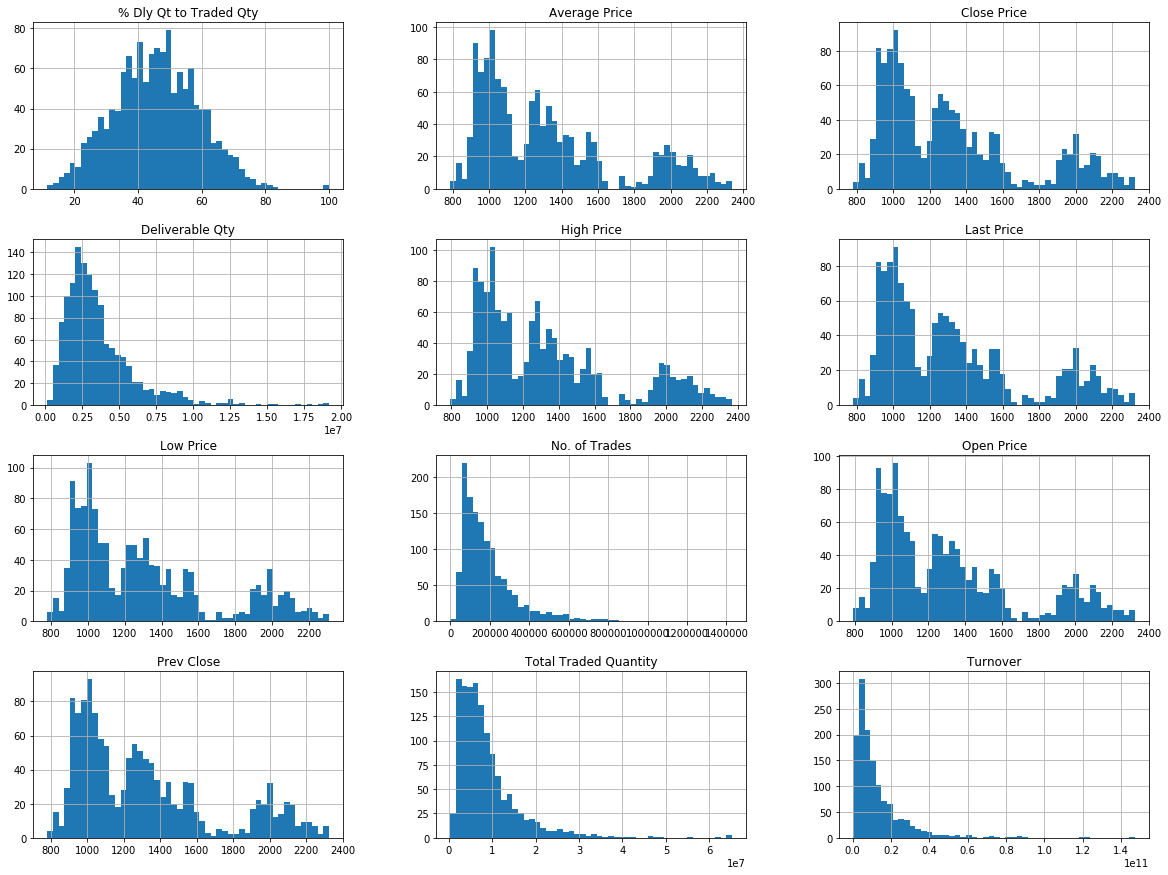

In [4]:
reliance_set.hist(bins=50, figsize=(20,15))
plt.show()

<p>Since a lot of the price features are shaped the same, if we do stratified sampling on one we should get good proportions of each feature's range in both sets</p>

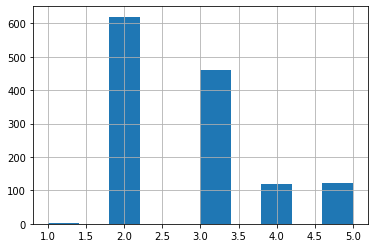

In [5]:
reliance_set["price_cat"] = pd.cut(reliance_set["Average Price"], bins=[0, 800, 1200, 1600, 2000, 2400], labels=[1,2,3,4,5])
reliance_set["price_cat"].hist()

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(reliance_set, reliance_set["price_cat"]):
    strat_train_set = reliance_set.loc[train_index]
    strat_test_set = reliance_set.loc[test_index]

In [7]:
strat_test_set["price_cat"].value_counts() / len(strat_test_set)

2    0.467925
3    0.347170
5    0.094340
4    0.090566
1    0.000000
Name: price_cat, dtype: float64

In [8]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("price_cat", axis=1, inplace=True)

<p>Now let's check out some of these correlations.</p>

In [9]:
rel_cpy = strat_train_set.copy()
corr_matrix = rel_cpy.corr()
corr_matrix["Close Price"].sort_values(ascending=False)

Close Price               1.000000
Last Price                0.999974
Average Price             0.999649
High Price                0.999246
Low Price                 0.999125
Open Price                0.998043
Prev Close                0.995330
Turnover                  0.616407
No. of Trades             0.507964
Total Traded Quantity     0.411089
Deliverable Qty           0.194749
% Dly Qt to Traded Qty   -0.556132
Name: Close Price, dtype: float64

<p>So as suspected, the different price features are highly correlated with the close price. Interestingly, it seems like the %Dly Qt to Traded Qty has strong negative correlation with the price.</p>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e15fee990>,
      dtype=object)

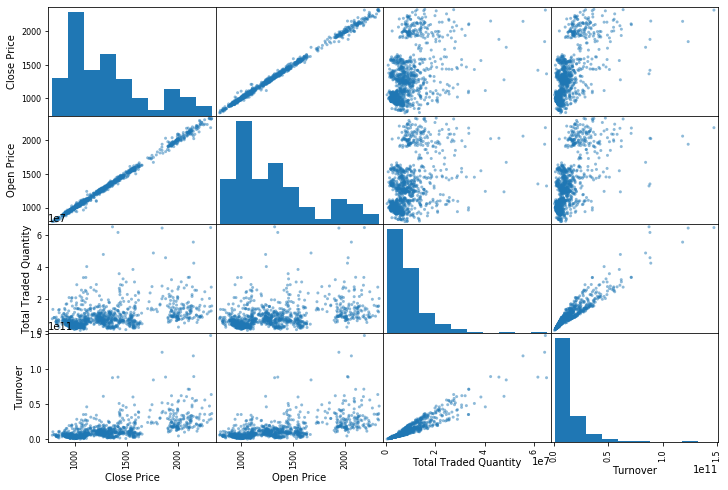

In [10]:
#lets look at a few of these correlations
from pandas.plotting import scatter_matrix

attributes = ["Close Price", "Open Price", "Total Traded Quantity", "Turnover"]
scatter_matrix(rel_cpy[attributes], figsize=(12, 8))

<p>So the obvious correlations are obvious, but we also see there may be slight correlation between TTQ and turnover. Time to do some dimensionality reduction.</p>

In [11]:
rel_cpy.drop(['Average Price', 'High Price', 'Low Price', 'Open Price'], axis=1, inplace=True)

<p>Will proceed trying two different models, one where we reduce the dimensionality by choosing the highest correlated price feature to represent all of them, and one where we leave all features in. This shouldn't be a problem as our feature vector isn't that large</p>

In [12]:
reliance_set.isnull().sum()

Symbol                    0
Series                    0
Date                      0
Prev Close                0
Open Price                0
High Price                0
Low Price                 0
Last Price                0
Close Price               0
Average Price             0
Total Traded Quantity     0
Turnover                  0
No. of Trades             0
Deliverable Qty           0
% Dly Qt to Traded Qty    0
price_cat                 0
dtype: int64

<p>Good news, the dataset is full so we won't need to use the SimpleImputer in our pipeline. We also can discard the symbol, series, and date fields since they're not really helping us.</p>

In [13]:
def clean_rel_data(reliance_dataset):
    return reliance_dataset.drop(['Symbol', 'Series', 'Date', 'Close Price'], axis=1)
reliance_set1 = clean_rel_data(strat_train_set)
reliance_labels1 = strat_train_set['Close Price'].copy()
reliance_set2 = clean_rel_data(rel_cpy)
reliance_labels2 = strat_train_set['Close Price'].copy()

<p>The data is prepped so now it's time to try some models on our different sets.</p>

In [14]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
#len(reliance_set1)
lin_reg.fit(reliance_set1, reliance_labels1)
lin_reg2 = LinearRegression()
lin_reg2.fit(reliance_set2, reliance_labels2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
from sklearn.metrics import mean_squared_error
rel1_predictions = lin_reg.predict(reliance_set1)
lin_mse = mean_squared_error(reliance_labels1, rel1_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.448933560185367

In [16]:
from sklearn.metrics import mean_squared_error
rel2_predictions = lin_reg2.predict(reliance_set2)
lin_mse = mean_squared_error(reliance_labels2, rel2_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.709901266941263

<p>So dropping the extra features didn't help, it hurt. Makes sense, we'll work with full set from now on. Let's also look at a few other models.</p>

In [17]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(reliance_set1, reliance_labels1)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [18]:
forest_pred = forest_reg.predict(reliance_set1)
forest_mse = mean_squared_error(reliance_labels1, forest_pred)
np.sqrt(forest_mse)

1.8351720693382942

In [19]:
from sklearn.svm import SVR
svm_reg = SVR()
svm_reg.fit(reliance_set1, reliance_labels1)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [20]:
svm_pred = svm_reg.predict(reliance_set1)
svm_mse = mean_squared_error(reliance_labels1, svm_pred)
np.sqrt(svm_mse)

339.0371146765652

<p>That was suprisingly bad, but I'm gonna do some hyperparameter tuning on SVM and Random Forest to see if I can improve performance. Before I do that though, I realized I forgot to scale down features to be between 0-1, which might affect things, going to use <b>StandardScaler</b> and see if it changes anything</p>

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rel_cpy = reliance_set1.copy()
scaler.fit_transform(rel_cpy)

array([[-0.88979194, -0.88900663, -0.91332042, ..., -0.61518984,
        -0.88394078,  1.02055984],
       [ 0.13410711,  0.14244193,  0.12702184, ..., -0.0697689 ,
         0.90701583,  1.38298648],
       [-0.10573104, -0.10905405, -0.10037467, ..., -0.45496274,
        -0.49199927,  1.33013259],
       ...,
       [ 0.66843009,  0.64635273,  0.61437418, ..., -0.53666647,
        -0.59571812,  1.14665411],
       [-1.23945142, -1.2434112 , -1.23969212, ..., -0.61620756,
         2.11003105,  1.47887853],
       [ 0.3191666 ,  0.34090849,  0.38736683, ...,  0.80958466,
         1.16672655,  0.58640292]])

In [22]:
forest_reg = RandomForestRegressor()
forest_reg.fit(reliance_set1, reliance_labels1)
forest_pred = forest_reg.predict(reliance_set1)
forest_mse = mean_squared_error(reliance_labels1, forest_pred)
np.sqrt(forest_mse)

1.7657895383693922

<p>Slightly worse so we'll stick with not scaled for now.</p>

In [23]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lin_reg, reliance_set1, reliance_labels1, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)
#we do negative because sklearn cross val wants a utility func not loss func
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(lin_rmse_scores)

Scores: [2.98324376 2.33651826 2.42272956 2.67196907 2.17574534 2.73897577
 2.66518618 2.24604084 2.61746208 2.32324187]
Mean: 2.5181112726103607
Standard deviation: 0.24322576381026856


In [24]:
forest_scores = cross_val_score(forest_reg, reliance_set1, reliance_labels1, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [6.05243337 6.27693182 4.71879935 4.88466153 2.84230009 7.31720679
 4.49157442 4.85732675 3.95806262 4.1497775 ]
Mean: 4.95490742315734
Standard deviation: 1.221584810860679


<p>Not going to look at SVM scores until we try different hyperparameters.</p>

In [25]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = forest_reg, param_distributions = random_grid, n_iter = 10, 
                               scoring = 'neg_mean_squared_error', cv = 5, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(reliance_set1, reliance_labels1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [26]:
from sklearn.model_selection import GridSearchCV
svr_param = {
    'kernel' : ('poly', 'rbf', 'sigmoid')
}
svr_grid = GridSearchCV(svm_reg, svr_param, cv=5, scoring='neg_mean_squared_error',verbose=2, return_train_score=True)
svr_grid.fit(reliance_set1, reliance_labels1)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] kernel=poly .....................................................
[CV] ...................................... kernel=poly, total=   0.1s
[CV] kernel=poly .....................................................
[CV] ...................................... kernel=poly, total=   0.0s
[CV] kernel=poly .....................................................
[CV] ...................................... kernel=poly, total=   0.0s
[CV] kernel=poly .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... kernel=poly, total=   0.0s
[CV] kernel=poly .....................................................
[CV] ...................................... kernel=poly, total=   0.1s
[CV] kernel=rbf ......................................................
[CV] ....................................... kernel=rbf, total=   0.0s
[CV] kernel=rbf ......................................................
[CV] ....................................... kernel=rbf, total=   0.0s
[CV] kernel=rbf ......................................................
[CV] ....................................... kernel=rbf, total=   0.0s
[CV] kernel=rbf ......................................................
[CV] ....................................... kernel=rbf, total=   0.0s
[CV] kernel=rbf ......................................................
[CV] ....................................... kernel=rbf, total=   0.0s
[CV] kernel=sigmoid ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'kernel': ('poly', 'rbf', 'sigmoid')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=2)

In [27]:
svm_cvres = svr_grid.cv_results_
for mean_score, params in zip(svm_cvres["mean_test_score"], svm_cvres["params"]):
    print(np.sqrt(-mean_score), params)

395.68837739993336 {'kernel': 'poly'}
347.791768506427 {'kernel': 'rbf'}
374.00666060963687 {'kernel': 'sigmoid'}


In [28]:
forest_cvres = rf_random.cv_results_
for mean_score, params in zip(forest_cvres["mean_test_score"], forest_cvres["params"]):
    print(np.sqrt(-mean_score), params)

11.03443523138226 {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
9.883654771261648 {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': False}
5.437850109054085 {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': False}
9.717915182119635 {'n_estimators': 1400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
6.722200909098906 {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}
9.585425253110131 {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}
5.472301771959331 {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'aut

<p>Since we have so much strongly correlated data, it makes sense that the linear has performed best. Let's check the accuracy on our best model.</p>

In [29]:
final_model = lin_reg
y_test = strat_test_set["Close Price"].copy()
X_test = clean_rel_data(strat_test_set)
final_preds = lin_reg.predict(X_test)

final_mse = mean_squared_error(y_test, final_preds)
final_rmse = np.sqrt(final_mse)
final_rmse

2.4037271327956873

In [31]:
from scipy import stats
confidence = 0.95
squared_errors = (final_preds - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([2.11909285, 2.6580545 ])

<p>I see this as an intresting conclusion, although some marginal improvements may be made using Ridge Regression or Lasso, we still are best off using a linear model, and get a decent degreee of accuracy.</p>